In [82]:
import numpy as np
import torch
from sklearn.neighbors import KNeighborsClassifier
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
train_folder_path = "/content/drive/MyDrive/APS360_Project/train_set"
validation_folder_path = "/content/drive/MyDrive/APS360_Project/val_set"
test_folder_path = "/content/drive/MyDrive/APS360_Project/test_set"

In [138]:
# resize to 32 by 32 and convert to tensor
transformation = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [161]:
def shuffled_dataset(root, transform):
  #seed the shuffling
  np.random.seed(42)

  # get dataset
  original_dataset = datasets.ImageFolder(root=root, transform=transform)
  # get number of samples
  num_samples = len(original_dataset)
  # shuffle the indices
  shuffled_indices = torch.randperm(num_samples)

  # Create a subset of the dataset with shuffled indices
  shuffled_set = torch.utils.data.Subset(original_dataset, shuffled_indices)
  return shuffled_set


# load datasets and apply transformation
# train_dataset = datasets.ImageFolder(root=train_folder_path, transform=transformation)
train_dataset = shuffled_dataset(root=train_folder_path, transform=transformation)
# validation_dataset = datasets.ImageFolder(root=validation_folder_path, transform=transformation)
validation_dataset = shuffled_dataset(root=validation_folder_path, transform=transformation)
# test_dataset = datasets.ImageFolder(root=test_folder_path, transform=transformation)
test_dataset = shuffled_dataset(root=test_folder_path, transform=transformation)

classes = ['Capacitor', 'LED', 'Potentiometer', 'Resistor', 'Transistor']

In [162]:
# get features by simply flattening pixel values
def extract_features(dataset):
  Features = []
  Labels = []
  for image, label in dataset:
    features = np.array(image.flatten())
    Features.append(features)
    Labels.append(label)
  Features = np.array(Features)
  Labels = np.array(Labels)
  return Features, Labels

In [163]:
train_features, train_labels = extract_features(train_dataset)
validation_features, validation_labels = extract_features(validation_dataset)
test_features, test_labels = extract_features(test_dataset)

In [164]:
train_accuracies = []
validation_accuracies = []
test_accuracies = []
average_accuracies = []

for k in range(1,31):
  baseline_model = KNeighborsClassifier(n_neighbors=k)
  # "train" the model (store the trainset in this case)
  baseline_model.fit(train_features, train_labels)
  # make predictions
  # train_predicts = baseline_model.predict(train_features)
  validation_predicts = baseline_model.predict(validation_features)
  test_predicts = baseline_model.predict(test_features)

  # train_accuracy = accuracy_score(train_predicts, train_labels)
  validation_accuracy = accuracy_score(validation_predicts, validation_labels)
  test_accuracy = accuracy_score(test_predicts, test_labels)

  # train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)
  test_accuracies.append(test_accuracy)
  average_accuracies.append((validation_accuracy+test_accuracy)/2)


In [165]:
def plot_accuracies(validation_accuracy, test_accuracy, average_accuracy, labels):
    plt.figure(figsize=(10, 6))

    # Check if all lists of accuracies have the same length
    if len(validation_accuracy) != len(test_accuracy):
        raise ValueError("All lists of accuracies must have the same length.")

    num_models = len(validation_accuracy)
    accuracies = [validation_accuracy, test_accuracy, average_accuracy]

    for i, (acc, color) in enumerate(zip(accuracies, plt.cm.tab10.colors)):
        x_coordinates = [x + i * 0.2 for x in range(num_models)]
        plt.plot(range(1, num_models + 1), acc, color=color, label=labels[i] if labels else f'Accuracy {i+1}')
    plt.xlabel('Number of Closest Neighbours with vote')
    plt.ylabel('Accuracy')
    plt.title('validation accuracies vs test accuracies vs average accuracies')
    # plt.xticks([x + 0.4 for x in range(num_models)], [f'Model {x+1}' for x in range(num_models)])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

the best validation accuracy is 0.6647398843930635 for k = 1
the best test accuracy is 0.6764705882352942 for k = 1
the best average accuracy is 0.6706052363141788 for k = 1


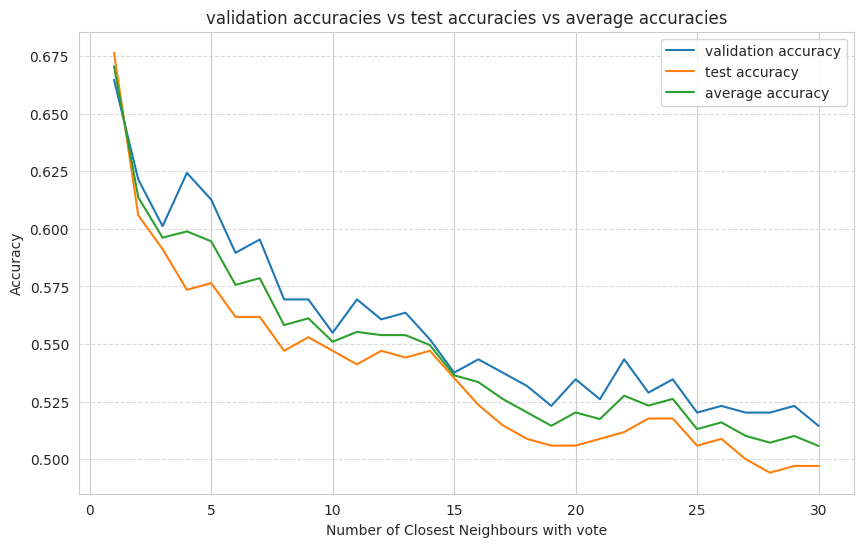

In [166]:
# print(f"the best train accuracy is {max(train_accuracies)} for k = {train_accuracies.index(max(train_accuracies)) + 1}")
print(f"the best validation accuracy is {max(validation_accuracies)} for k = {validation_accuracies.index(max(validation_accuracies)) + 1}")
print(f"the best test accuracy is {max(test_accuracies)} for k = {test_accuracies.index(max(test_accuracies)) + 1}")
print(f"the best average accuracy is {max(average_accuracies)} for k = {average_accuracies.index(max(average_accuracies)) + 1}")
plot_accuracies(validation_accuracies, test_accuracies, average_accuracies, ['validation accuracy' ,'test accuracy', 'average accuracy'])

In [167]:
# it can be seen that this baseline model produces the best result when k = 1

In [168]:
# make decision boundaries with k=1
# all code below is inspired by https://www.tvhahn.com/posts/beautiful-plots-decision-boundary/
# with modifications
from matplotlib.colors import ListedColormap
import seaborn as sns

In [169]:
X = train_features[:, 0:2]
Y = train_labels

In [170]:
# make sure sizes are correct
print(f'features.shape: {X.shape}')
print(f'labels.shape: {Y.shape}')

features.shape: (1077, 2)
labels.shape: (1077,)


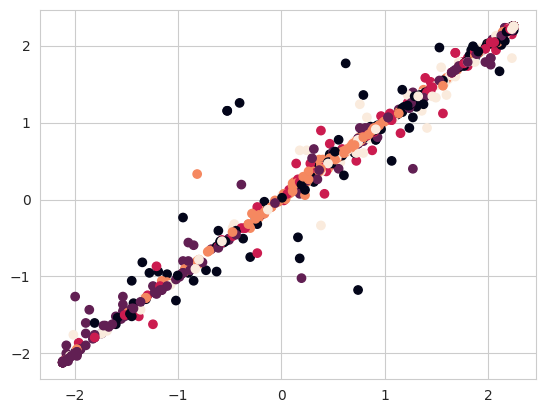

In [171]:
x0 = X[:,0]
x1 = X[:,1]

plt.scatter(x0, x1, c=Y)
plt.show()

In [172]:
# "train" it with two features from each image
baseline_model = KNeighborsClassifier(n_neighbors=1)
baseline_model.fit(X, Y)

KNeighborsClassifier(n_neighbors=1)

In [173]:
# make paddings
padding = 1

# define graphing boundaries
x0_min, x0_max = np.round(x0.min())-padding, np.round(x0.max()+padding)
x1_min, x1_max = np.round(x1.min())-padding, np.round(x1.max()+padding)

In [174]:
# mesh stepsize
step_size = 0.1

x0_axis_range = np.arange(x0_min, x0_max, step_size)
x1_axis_range = np.arange(x1_min, x1_max, step_size)

In [175]:
xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)

In [176]:
xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
xx.shape

(3600, 2)

In [177]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [178]:
# prediction of all the little dots
yy_hat = baseline_model.predict(xx)

# probability of each dot being the predicted color
# it is going to be 1 for one of the classes in this
# case as we are only using one neighbor
yy_prob = baseline_model.predict_proba(xx)

# the size of each probability dot
yy_size = np.max(yy_prob, axis=1)

# prediction types
print(set(yy_hat))

{0, 1, 2, 3, 4}


In [179]:
# modifier to scale the probability dots
PROB_DOT_SCALE = 40
# exponential used to increase/decrease size of prob dots
PROB_DOT_SCALE_POWER = 3
# size of the true labels
TRUE_DOT_SIZE = 50

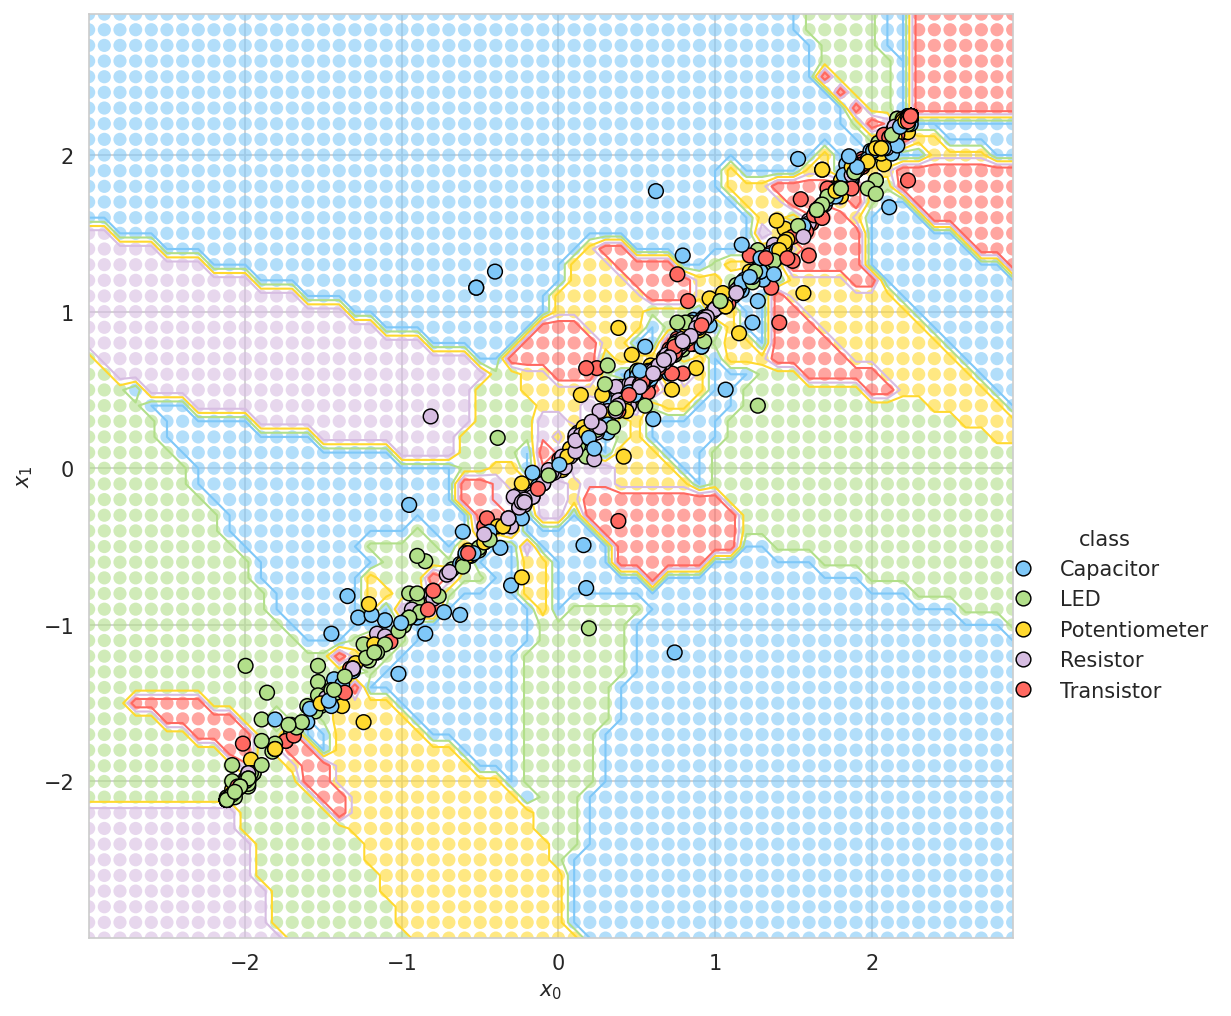

In [180]:
from matplotlib.ticker import MaxNLocator # needed for integer only on axis
from matplotlib.lines import Line2D # for creating the custom legend

# make figure
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=150)

# establish a colormap
colormap = np.array(['#7FC8F8', '#B2DF8A', '#FFD92F', '#D7BDE2', '#FF6961'])

ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.6,
           s=PROB_DOT_SCALE*yy_size**PROB_DOT_SCALE_POWER, linewidths=0,)

# plot the contours
# * we have to reshape the yy_hat to get it into a
#   2D dimensional format, representing both the x0
#   and x1 axis
ax.contour(x0_axis_range, x1_axis_range,
           np.reshape(yy_hat,(xx0.shape[0],-1)),
           levels=5, linewidths=1,
           colors=colormap)

# plot the original x values.
# * zorder is 3 so that the dots appear above all the other dots
ax.scatter(X[:,0], X[:,1], c=colormap[Y], s=TRUE_DOT_SIZE, zorder=3,
           linewidths=0.7, edgecolor='k')

# create legends
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

ax.set_ylabel(r"$x_1$")
ax.set_xlabel(r"$x_0$")

# create class legend
# Line2D properties: https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html
# about size of scatter plot points: https://stackoverflow.com/a/47403507/9214620
legend_class = []
for component_class, color in zip(classes, colormap):
    legend_class.append(Line2D([0], [0], marker='o', label=component_class,ls='None',
                               markerfacecolor=color, markersize=np.sqrt(TRUE_DOT_SIZE),
                               markeredgecolor='k', markeredgewidth=0.7))


legend1 = ax.legend(handles=legend_class, loc='center',
                    bbox_to_anchor=(1.1, 0.35),
                    frameon=False, title='class')

# only use integers for axis tick labels
# from: https://stackoverflow.com/a/34880501/9214620
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# remove first ticks from axis labels, for looks
# from: https://stackoverflow.com/a/19503828/9214620
ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])

ax.set_aspect(1)

plt.show()
